# Import packages

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Load HSC and endothelium from DS-FBM and non-DS FBM

# Import the FBM HSC and endo

In [3]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20200718.h5ad')

In [4]:
adata.shape

(104562, 33712)

In [5]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell             327
CD8 T cell             171
CD14 monocyte         8787
CD56 bright NK         450
CMP                    425
                      ... 
schwann cells            9
sinusoidal EC          550
stromal macrophage    1493
tDC                    193
tip EC                 363
Length: 64, dtype: int64

In [6]:
from scipy import sparse
array_vals = adata.X
adata.X = sparse.csr_matrix(adata.X)
adata.raw = adata
adata.X = array_vals

In [7]:
adata = adata[adata.obs['cell.labels'].isin(['HSC', 'sinusoidal EC',  
                                            'proliferating EC', 'tip EC'])].copy()

In [8]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
HSC                  92
proliferating EC     26
sinusoidal EC       550
tip EC              363
dtype: int64

In [9]:
adata.obs['cell.labels'] = adata.obs['cell.labels'].replace(["proliferating EC", "sinusoidal EC", 
                                                             "tip EC"], ["endothelium", "endothelium", 
                                                                        "endothelium"])

In [10]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
HSC             92
endothelium    939
dtype: int64

In [11]:
adata.obs["dataset"] = "fbm"

In [12]:
fbm = adata

# Import the DS HSC and endo

In [13]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/downs_bm/data/downs_raw_dr_20200714.h5ad')

In [14]:
adata.shape

(8622, 33694)

In [15]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CAR                          4
CD8 T cell                  55
CD14 monocyte              252
CD56 bright NK              36
CMP                         37
DC1                         16
DC2                         94
DC3                         98
HSC                         45
ILC precursor               13
MEMP                        42
MK                          25
MOP                        350
MSC                         18
Treg                         8
chondrocyte                  4
early B cell                23
early MK                     7
early erythroid            766
endothelium                 37
eo/baso/mast precursor      40
eosinophil                  41
late erythroid            3341
macrophage                  64
mast cell                   27
mature B cell               20
mature NK                   69
mid erythroid             2082
myelocyte                  218
neutrophil                 245
osteoblast                  11
osteoclast                 

In [16]:
adata = adata[adata.obs['cell.labels'].isin(['HSC', 'endothelium'])].copy()

In [17]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
HSC            45
endothelium    37
dtype: int64

In [18]:
adata.obs["dataset"] = "ds_fbm"
ds_fbm = adata

# Combine the datasets

In [19]:
from scipy import sparse

objects = [ds_fbm, fbm]

for i in objects:
    array_vals = i.X
    i.X = sparse.csr_matrix(i.X)
    i.raw = i
    i.X = array_vals

In [20]:
merged = fbm.concatenate(ds_fbm, index_unique=None, join='inner')

In [21]:
merged.shape

(1113, 33694)

In [22]:
cell_numbers = merged.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
HSC            137
endothelium    976
dtype: int64

In [23]:
merged.obs["dataset_cell.labels"] = merged.obs["dataset"].astype(str) + '_' + merged.obs["cell.labels"].astype(str)

In [24]:
cell_numbers = merged.obs.groupby(["dataset_cell.labels"]).apply(len)
cell_numbers

dataset_cell.labels
ds_fbm_HSC             45
ds_fbm_endothelium     37
fbm_HSC                92
fbm_endothelium       939
dtype: int64

# Pre-process the data

In [25]:
adata=merged

In [26]:
# normalise count data 
sc.pp.normalize_total(adata)

In [27]:
# log the count data 
sc.pp.log1p(adata)

In [28]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [29]:
# scale the data 
sc.pp.scale(adata, max_value=10)
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

# Run violin plots for HSC

In [30]:
cell_numbers = adata.obs.groupby(["dataset_cell.labels"]).apply(len)
cell_numbers

dataset_cell.labels
ds_fbm_HSC             45
ds_fbm_endothelium     37
fbm_HSC                92
fbm_endothelium       939
dtype: int64

In [31]:
hsc_genes=["NRP2", "ESAM", "FGFR1", "NOTCH1", "TNFRSF10C", "KRT19", "CD44", "NOTCH2", "KRT19", "NRP2", "KRT19", 
          "FZD6", "PLAUR", "SELL", "KIT", "MERTK", "KRT19", "CD46", "FLT3", "JAM3", "KRT19"]

... storing 'age' as categorical
... storing 'april_cell.labels' as categorical
... storing 'auto_prd' as categorical
... storing 'cell.labels' as categorical
... storing 'cell.labels_20200708' as categorical
... storing 'cell.labels_20200713' as categorical
... storing 'cell.labels_20200718' as categorical
... storing 'dataset' as categorical
... storing 'doublets' as categorical
... storing 'fetal.ids' as categorical
... storing 'gender' as categorical
... storing 'is_doublet' as categorical
... storing 'is_doublet_poptrim' as categorical
... storing 'is_doublet_wolock' as categorical
... storing 'lanes' as categorical
... storing 'mad_prd' as categorical
... storing 'nk_meta' as categorical
... storing 'orig.ident' as categorical
... storing 'processing.type' as categorical
... storing 'sequencing.type' as categorical
... storing 'sort.ids' as categorical


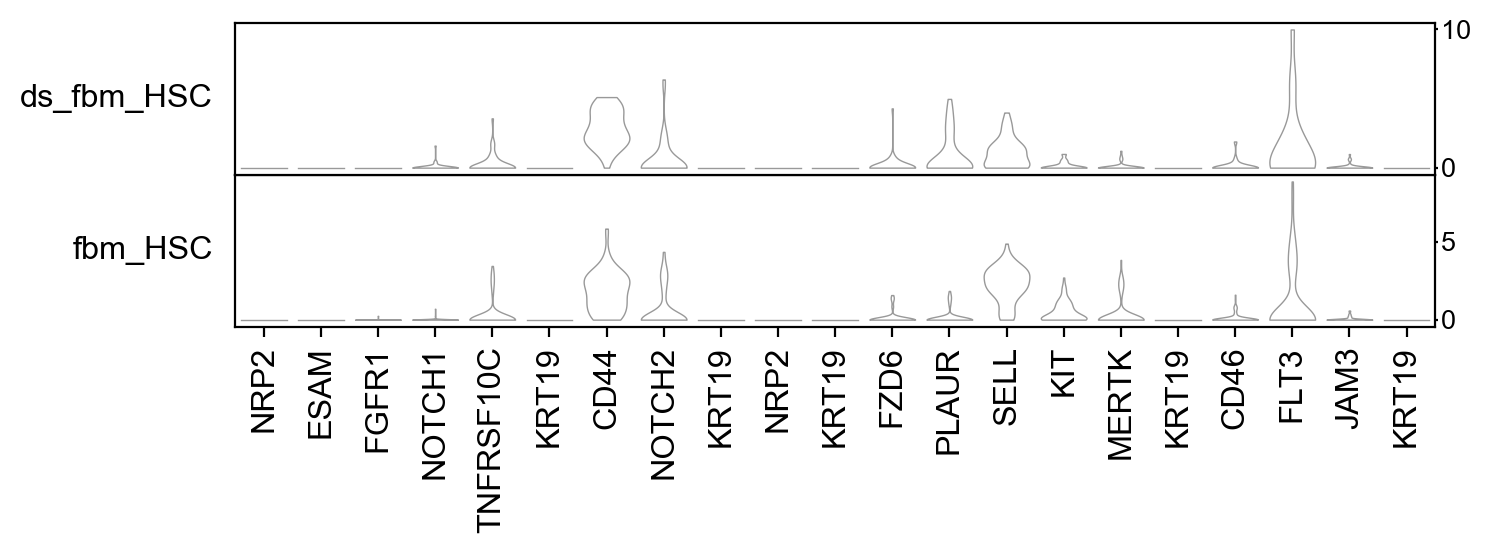

In [32]:
sc.settings.set_figure_params(dpi=100, dpi_save=1000)

adata.obs["dataset_cell.labels"] = adata.obs["dataset_cell.labels"].astype("category")

subset = adata[adata.obs['dataset_cell.labels'].isin(['ds_fbm_HSC', 'fbm_HSC'])].copy()

subset.obs["dataset_cell.labels"] = subset.obs["dataset_cell.labels"].cat.reorder_categories(
    ['ds_fbm_HSC', 'fbm_HSC'])

sc.pl.stacked_violin(subset, var_names=hsc_genes, save="hsc_ds_nonds_fbm_violin_20200722.pdf", 
                     rotation=90, 
                     groupby='dataset_cell.labels', use_raw=False, swap_axes=False, figsize=(8,2), 
                     row_palette=["#ffffff", "#ffffff"])

In [33]:
subset = adata[:, hsc_genes].copy()

sc.tl.rank_genes_groups(subset, groupby='dataset_cell.labels', method='wilcoxon', use_raw=False, 
                        log_transformed=True, groups=['ds_fbm_HSC', 'fbm_HSC'], n_genes=subset.shape[1])

# save df for filtered degs
result = subset.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs_by_cluster = pd.DataFrame({group + '_' + key[:7]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'pvals', 'pvals_adj']})
# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/figs/clustering_degs/fig6d_hsc_ds_nonds_fbm_violin_degs_20200722.csv")
degs_by_cluster

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'age' as categorical
... storing 'april_cell.labels' as categorical
... storing 'auto_prd' as categorical
... storing 'cell.labels' as categorical
... storing 'cell.labels_20200708' as categorical
... storing 'cell.labels_20200713' as categorical
... storing 'cell.labels_20200718' as categorical
... storing 'dataset' as categorical
... storing 'doublets' as categorical
... storing 'fetal.ids' as categorical
... storing 'gender' as categorical
... storing 'is_doublet' as categorical
... storing 'is_doublet_poptrim' as categorical
... storing 'is_doublet_wolock' as categorical
... storing 'lanes' as categorical
... storing 'mad_prd' as categorical
... storing 'nk_meta' as categorical
... storing 'orig.ident' as categorical
... storing 'processing.type' as categorical
... storing 'sequencing.type' as categorical
... storing 'sort.ids' as categorical
... storing 'gene_ids-1' as categorical


,ds_fbm_HSC_names,ds_fbm_HSC_logfold,ds_fbm_HSC_pvals,ds_fbm_HSC_pvals_a,fbm_HSC_names,fbm_HSC_logfold,fbm_HSC_pvals,fbm_HSC_pvals_a
0,CD44,6.223911,1.226748e-25,2.576172e-24,SELL,5.346089,4.590422e-43,9.639886e-42
1,SELL,2.302608,7.404274e-10,3.109795e-09,CD44,4.745214,4.197826e-36,4.407717e-35
2,FLT3,5.401942,5.394167e-07,1.618250e-06,KIT,0.458754,1.853929e-05,3.893251e-05
3,PLAUR,2.344579,3.712459e-04,7.796164e-04,FLT3,4.779695,1.172921e-04,2.239213e-04
4,NOTCH2,2.106556,2.528904e-02,4.425582e-02,NOTCH2,2.354777,2.427755e-03,4.248572e-03
5,TNFRSF10C,0.373705,1.047079e-01,1.691435e-01,MERTK,0.617120,2.627606e-01,4.244594e-01
6,FZD6,-0.998851,8.004136e-01,9.915009e-01,TNFRSF10C,0.470308,3.559348e-01,4.983087e-01
7,MERTK,-1.699085,8.139798e-01,9.915009e-01,PLAUR,-0.930031,9.091407e-01,9.875714e-01
8,KRT19,-23.165344,9.915009e-01,9.915009e-01,KRT19,-23.230585,9.875714e-01,9.875714e-01
9,KRT19,-23.165344,9.915009e-01,9.915009e-01,KRT19,-23.230585,9.875714e-01,9.875714e-01


# Run violin plots for endo

In [34]:
cell_numbers = adata.obs.groupby(["dataset_cell.labels"]).apply(len)
cell_numbers

dataset_cell.labels
ds_fbm_HSC             45
ds_fbm_endothelium     37
fbm_HSC                92
fbm_endothelium       939
dtype: int64

In [35]:
endo_genes=["PGF", "ESAM", "FGF7", "DLK1", "TNFSF10", "NOV", "SELE", "DLL4", "SEMA3F", "VEGFA", "HBEGF", 
           "WNT5A", "ITGA4", "CD34", "KITLG", "GAS6", "JAG2", "JAG1", "FLT3LG", "JAM3", "FGFR2"]

... storing 'age' as categorical
... storing 'april_cell.labels' as categorical
... storing 'auto_prd' as categorical
... storing 'cell.labels' as categorical
... storing 'cell.labels_20200708' as categorical
... storing 'cell.labels_20200713' as categorical
... storing 'cell.labels_20200718' as categorical
... storing 'dataset' as categorical
... storing 'doublets' as categorical
... storing 'fetal.ids' as categorical
... storing 'gender' as categorical
... storing 'is_doublet' as categorical
... storing 'is_doublet_poptrim' as categorical
... storing 'is_doublet_wolock' as categorical
... storing 'lanes' as categorical
... storing 'mad_prd' as categorical
... storing 'nk_meta' as categorical
... storing 'orig.ident' as categorical
... storing 'processing.type' as categorical
... storing 'sequencing.type' as categorical
... storing 'sort.ids' as categorical


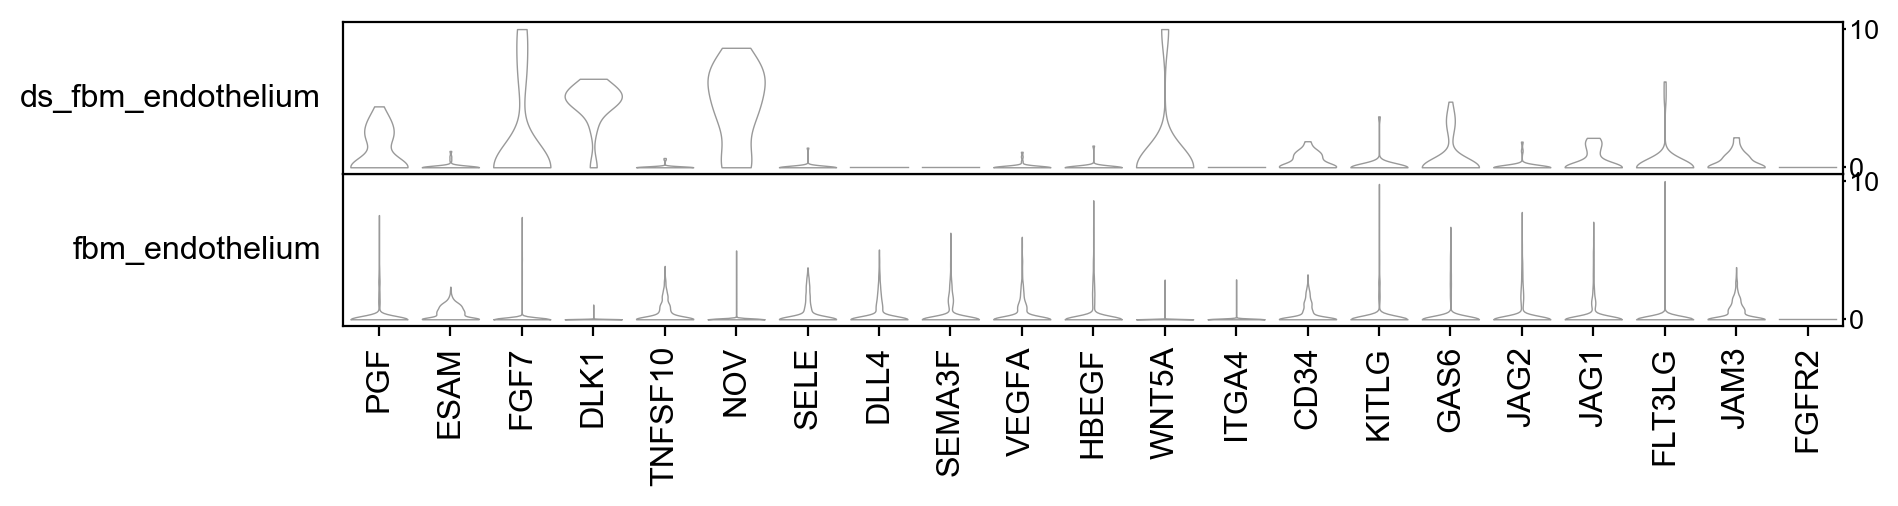

In [36]:
sc.settings.set_figure_params(dpi=100, dpi_save=1000)

adata.obs["dataset_cell.labels"] = adata.obs["dataset_cell.labels"].astype("category")

subset = adata[adata.obs['dataset_cell.labels'].isin(['ds_fbm_endothelium', 'fbm_endothelium'])].copy()

subset.obs["dataset_cell.labels"] = subset.obs["dataset_cell.labels"].cat.reorder_categories(
    ['ds_fbm_endothelium', 'fbm_endothelium'])

sc.pl.stacked_violin(subset, var_names=endo_genes, save="endo_ds_nonds_fbm_violin_20200722.pdf", 
                     rotation=90, 
                     groupby='dataset_cell.labels', use_raw=False, swap_axes=False, figsize=(10,2), 
                     row_palette=["#ffffff", "#ffffff"])

In [37]:
subset = adata[:, endo_genes].copy()

sc.tl.rank_genes_groups(subset, groupby='dataset_cell.labels', method='wilcoxon', use_raw=False, 
                        log_transformed=True, groups=['ds_fbm_endothelium', 'fbm_endothelium'], 
                        n_genes=subset.shape[1])

# save df for filtered degs
result = subset.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs_by_cluster = pd.DataFrame({group + '_' + key[:7]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'pvals', 'pvals_adj']})
# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/figs/clustering_degs/fig6d_endo_ds_nonds_fbm_violin_degs_20200722.csv")
degs_by_cluster

... storing 'age' as categorical
... storing 'april_cell.labels' as categorical
... storing 'auto_prd' as categorical
... storing 'cell.labels' as categorical
... storing 'cell.labels_20200708' as categorical
... storing 'cell.labels_20200713' as categorical
... storing 'cell.labels_20200718' as categorical
... storing 'dataset' as categorical
... storing 'doublets' as categorical
... storing 'fetal.ids' as categorical
... storing 'gender' as categorical
... storing 'is_doublet' as categorical
... storing 'is_doublet_poptrim' as categorical
... storing 'is_doublet_wolock' as categorical
... storing 'lanes' as categorical
... storing 'mad_prd' as categorical
... storing 'nk_meta' as categorical
... storing 'orig.ident' as categorical
... storing 'processing.type' as categorical
... storing 'sequencing.type' as categorical
... storing 'sort.ids' as categorical


,ds_fbm_endothelium_names,ds_fbm_endothelium_logfold,ds_fbm_endothelium_pvals,ds_fbm_endothelium_pvals_a,fbm_endothelium_names,fbm_endothelium_logfold,fbm_endothelium_pvals,fbm_endothelium_pvals_a
0,DLK1,9.895652e+00,3.997804e-21,8.395388e-20,ESAM,5.439081e+00,2.544716e-47,1.781301e-46
1,NOV,1.203394e+01,6.198335e-17,6.508252e-16,SELE,6.182419e+00,1.153724e-12,6.057049e-12
2,PGF,3.197560e+00,9.947304e-05,4.177868e-04,VEGFA,5.399294e+00,2.521480e-11,1.059022e-10
3,FGF7,5.782570e+00,3.782387e-02,8.681756e-02,JAM3,2.112661e+00,2.722790e-10,9.529763e-10
4,JAG1,8.558387e-01,5.899930e-02,1.126350e-01,DLL4,7.319346e+00,1.691842e-09,5.075526e-09
5,CD34,1.736687e-01,2.341969e-01,3.480577e-01,SEMA3F,2.894285e+01,2.181649e-06,5.726829e-06
6,GAS6,1.707785e+00,2.486126e-01,3.480577e-01,TNFSF10,1.307749e+00,3.931057e-05,9.172465e-05
7,WNT5A,9.510575e+00,2.666492e-01,3.499771e-01,JAG2,4.641528e+00,1.417270e-03,2.480223e-03
8,FLT3LG,1.160722e+00,7.909910e-01,8.742532e-01,KITLG,3.921101e+00,6.251943e-02,9.377915e-02
9,JAM3,-1.032901e-02,9.919070e-01,1.000000e+00,JAG1,1.676055e+00,9.355213e-02,1.309730e-01
